# Application 4: Time Dependent Systems (evolution in the reduced space)

Contributed by: Pablo Giuliani, Kyle Godbey, Edgard Bonilla

In this section we are going to take a look at the time evolution of a quantum system using the reduced basis method ([take a look here for an example practical and more complex non-quantum application](https://doi.org/10.1016/j.cma.2006.08.004)). We will focus on the harmonic oscillator for our first exploration (we will try a self interacting particle in the next chapter about non-linear systems). Our Hamiltonian is:

\begin{equation}
    H = -\frac{\partial^2}{\partial x^2} + \omega^2 x^2
\end{equation}

Let us drop the numerical constants to simplify notation ($\hbar=1$).

The evolution of a quantum mechanical wave function is [described through Schrodinger equation as](https://en.wikipedia.org/wiki/Hamiltonian_(quantum_mechanics)#Schr%C3%B6dinger_equation):

\begin{equation}
    H \left| \phi (t,x) \right\rangle = i  {\partial\over\partial t} \left| \phi (t,x) \right\rangle,
\end{equation}

which results in the evolution operator from an initial state:

\begin{equation}
    \left| \phi (t,x) \right\rangle = e^{-iHt} | \phi (0,x) \rangle.
\end{equation}

To solve the problem numerically, the evolution operator is usually expanded in its Taylor approximation and a finite time step $\Delta t$ is taken:

\begin{equation}
    \left| \phi (\Delta t,x) \right\rangle \approx \big(1 + (-iH\Delta t) + \frac{1}{2} (-iH\Delta t)^2 + ... \big) | \phi (0,x) \rangle.
\end{equation}

In this chapter, we will still use the evolution operator to study the dynamics of the system, but we will build it in the reduced space.  The state $\phi(x,t)$ will be transformed into their reduced approximations:

\begin{equation}
    \phi(x,t) \approx \hat \phi(x,t) = \sum_k^n a_k(t) \phi_k(x),
\end{equation}

where now the coefficients $a_k$ explicitely depend on time (as well as any parameters of the system). The Hamiltonian will be transformed in a reduced version as well when substituting the reduced basis approximation and doing a Galerkin projection of the dynamic evolution equaiton. Using our previous notation we have:

\begin{equation}
   F_\alpha[ \phi(x,t) ]=  {\partial\over\partial t} \phi (t,x) +iH\phi (t,x) =0,
\end{equation}

we can substitude $\phi(x,t)$ with $\hat \phi(x,t)$ and project:

\begin{equation}
   \langle \phi_j(x) | F_\alpha[ \hat \phi(x,t) ] \rangle =0 \ \text{for j=1, ... n}.
\end{equation}

We will choose our $\phi_k$ as the Pricinpal Components of several snapshots, meaning that $\langle \phi_j | \phi_k\rangle = \delta_j^k$, which leads to the dynamic equations for the coefficients:

\begin{equation}
 \frac{d}{dt}a_j(t) - i\hat H \boldsymbol{a}(t) =0,
\end{equation}

where $\boldsymbol{a}(t) = \{a_1(t), ... a_n(t) \}$ and the reduced Hamiltonian is computed as:

\begin{equation}
    \hat H_{j,k} = \langle \phi_j | H | \phi_k \rangle.
\end{equation}

We now have to solve for the evolution of $n$ (usually small) number of coefficients in time. The RBM solution will be much more efficient in time thanks to both the fact that $n\ll N$ ($N$ being the dimension of the traditional high fidelity solver), and that $\Delta t$ can be taken appreciably bigger and still recover a stable solution.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from scipy.integrate import solve_ivp
from scipy.linalg import expm
from scipy.linalg import lstsq

from scipy.interpolate import CubicSpline
import time
import math
import timeit



# High fidelity solver approach

We beging by creating the derivative operator and the evolution equations in the high fidelity solver approach through a finite element method

In [8]:
def generate_second_derivative_matrix(N, dx):
    # Generate the matrix for the second derivative using a five-point stencil
    main_diag = np.ones(N) * (-5.0 /2 / dx**2)
    off_diag = np.ones(N - 1)* 4/3 / dx**2
    off_diag2 = np.ones(N - 2) * (-1.0 / (12 * dx**2))
    
    D2 = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1) + np.diag(off_diag2, k=2) + np.diag(off_diag2, k=-2)
    
    # Modify the matrix for the Dirichlet boundary conditions
    D2[0, 0] = -15.0 /12 / dx**2
    D2[1, 0] = 15 /12 / dx**2
    D2[0, 1] = 16/12/dx**2
    
    D2[-1, -1] = -15 /12 / dx**2
    D2[-2, -1] = 15 /12 / dx**2
    D2[-1, -2] = 16/12/dx**2
    
    return D2


In [9]:
#delay in seconds for the movies, since we are going to produce a lot of them!
frame_per_second=60

x_max = 10.0  # Maximum coordinate value for the grid

N_grid=150
# Set up the coordinate grid
x = np.linspace(-x_max, x_max, N_grid)
dx = x[1] - x[0]
D2 = generate_second_derivative_matrix(N_grid, dx)
Omega_Val0=1

In [10]:
#We will fix the initial state of our system, but you can chance it and see what happens

initial_state = np.exp(-(x-0.2)**2 / 2.0) / np.sqrt(np.pi)

In [11]:
def harmonic_oscillator_time_evolution(initial_state, total_time, time_steps, omega,total_order,N_grid):

    
    
    time_step_size=total_time/time_steps
    
    
    x = np.linspace(-x_max, x_max, N_grid)
    dx = x[1] - x[0]
    D2 = generate_second_derivative_matrix(N_grid, dx)
    
    initial_state = np.exp(-(x-0.2)**2 / 2.0) / np.sqrt(np.pi)
    
    
    # Compute the potential energy term
    V = 0.5 * omega**2 * x**2
    
    # Set up the Hamiltonian matrix
    H = -D2 + np.diag(V)



    # Compute the time evolution
    state_evolution = []
    rho_evolution=[]
   
    
    current_state = initial_state/np.sqrt(np.dot(initial_state,np.conj(initial_state))*dx)
    
    
    state_evolution.append(current_state)
    rho_evolution.append(np.real(current_state*np.conj(current_state)))
    
    
    for _ in range(time_steps):

        next_state= np.copy(current_state)
    
        current_correction=np.copy(current_state)
        
        for j in range(1,total_order+1):
            current_correction = np.dot( (-1j/j)*time_step_size*H,current_correction)
            next_state= next_state + current_correction
        
  
        
        
        next_state = next_state/np.sqrt(np.dot(next_state,np.conj(next_state))*dx)
        
        state_evolution.append(next_state)
        rho_evolution.append(np.real(next_state*np.conj(next_state)))
        current_state = next_state

    return [np.array(state_evolution),np.array(rho_evolution)]


In [12]:
%%time
HF_results0=harmonic_oscillator_time_evolution(initial_state, 10, 10000, Omega_Val0,4,150)


CPU times: user 25.8 s, sys: 43.2 s, total: 1min 9s
Wall time: 3.46 s


In [13]:
seconds_total=10
#Approximately how long we want our movie to last

In [14]:
rho_HF0=HF_results0[1][::math.ceil(len(HF_results0[1])/(frame_per_second*seconds_total))]

In [15]:
wf_HF0=HF_results0[0][::math.ceil(len(HF_results0[0])/(frame_per_second*seconds_total))]

In [16]:
def Movie_Maker(wf_lists,rholists,Omega_Value,name):

    fig = plt.figure(dpi=200)
    ax = plt.axes(xlim=(-4, 4), ylim=(-2, 2))
    ax.plot(x,0.5 * Omega_Value**2 * x**2)
    plt.plot(x,initial_state/np.sqrt((np.dot(initial_state,np.conj(initial_state))*dx)),color='k',alpha=0.5)
    line, = ax.plot([], [], lw=3,color='b',alpha=0.5)
    line2, = ax.plot([], [], lw=3,linestyle='dashed',color='r',alpha=0.5)
    line3, = ax.plot([], [], lw=3,color='orange',alpha=0.5)

    def init():
        line.set_data([], [])
        return line,
    def animate(i):


        line.set_data(x,np.real(wf_lists[i]) )
        line2.set_data(x,np.imag(wf_lists[i]) )
        line3.set_data(x,rholists[i])
        return line,

#     anim = FuncAnimation(fig, animate, init_func=init,
#                                    frames=len(wf_lists), interval=frame_delay*1000, blit=True)

    
    anim = FuncAnimation(fig, animate, init_func=init,
                                   frames=len(wf_lists), blit=True)
    
    
    FFwriter = animation.FFMpegWriter(fps=frame_per_second)
    anim.save(name+'.mp4', writer=FFwriter)

If you are running this notebook locally, the following command will produce a movie of the real and imaginary part of the wave function, together with the density, all across 10 units of time. For the webpage version it is commented out to not break the book.

CPU times: user 10.4 s, sys: 958 ms, total: 11.4 s
Wall time: 11.9 s


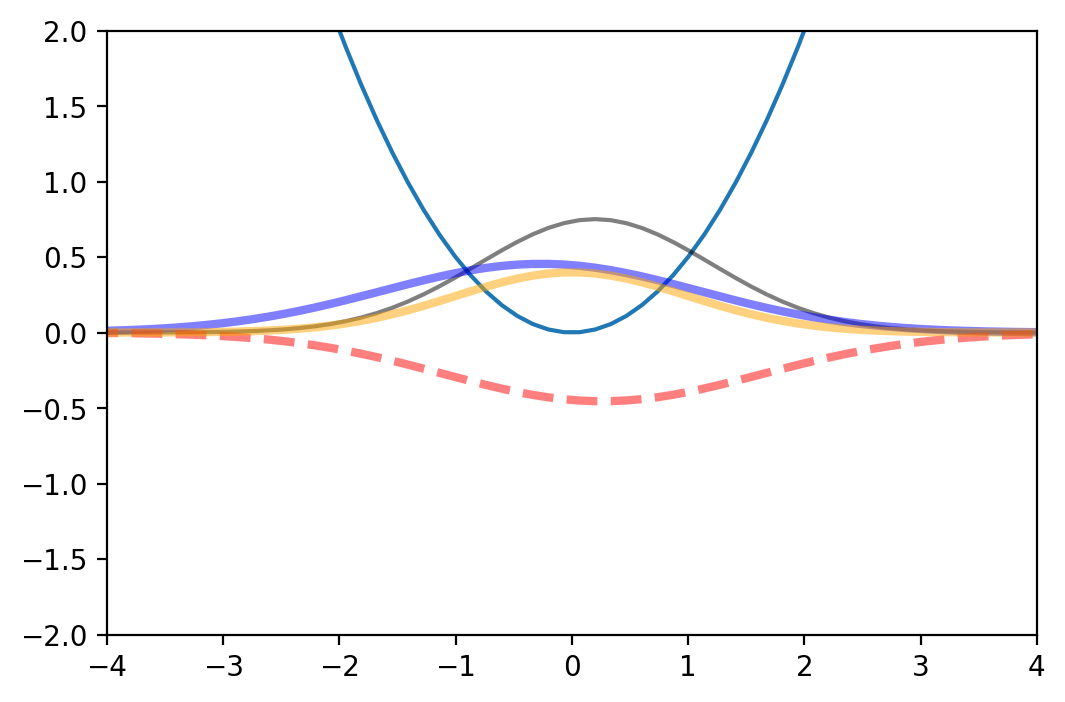

In [17]:
# %%time
# Movie_Maker(wf_HF0,rho_HF0,Omega_Val0,'HF_solver')

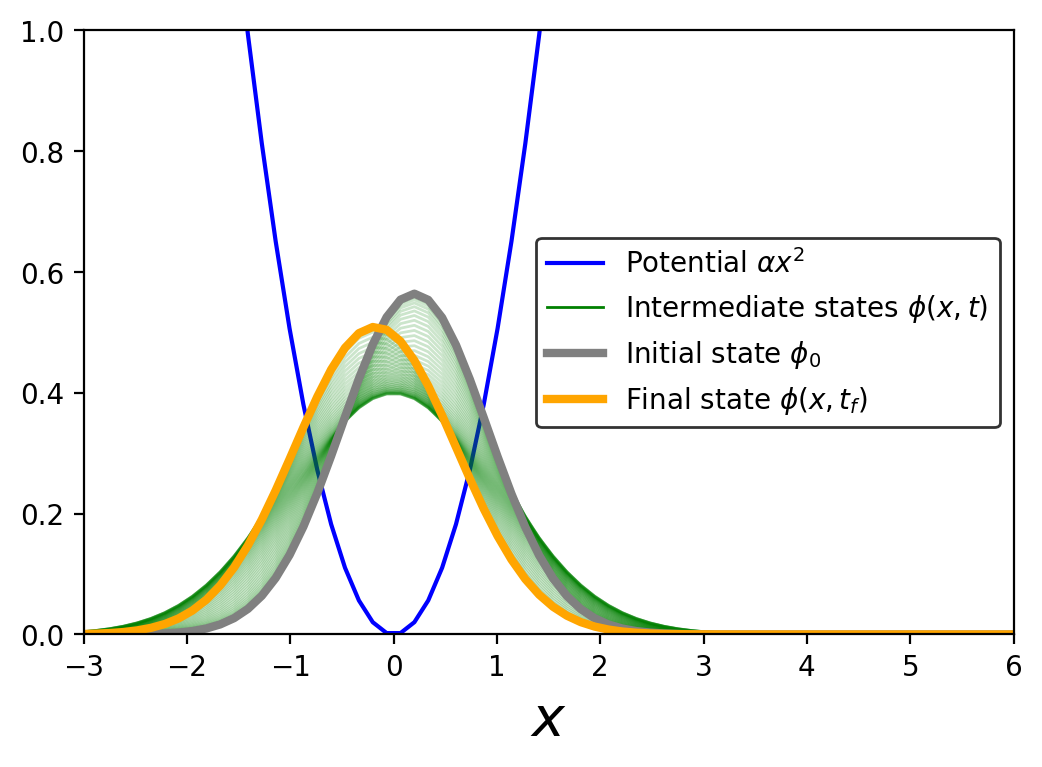

In [18]:
fig = plt.figure(dpi=200)
plt.plot(x,0.5 * 1**2 * x**2,color='b',
         label=r'Potential $\alpha x^2$' )

plt.plot(x,rho_HF0[0],color='g',linewidth=1,label=r'Intermediate states $\phi(x,t)$')

for ij in range(55):
    plt.plot(x,rho_HF0[ij*2],color='g',linewidth=1,alpha=0.2)
plt.plot(x,rho_HF0[0],color='grey',linewidth=3,label=r'Initial state $\phi_0$' )
plt.plot(x,rho_HF0[110],color='orange',linewidth=3,label=r'Final state $\phi(x,t_f)$')


# plt.plot(x,initial_state*np.conj(initial_state)/(np.dot(initial_state,np.conj(initial_state))*dx),color='r',alpha=0.5)
plt.xlim(-3,6)
plt.ylim(0,1)
plt.legend(fontsize=10,frameon=True, edgecolor='black') 
plt.xlabel(r'$x$',fontsize=20)
plt.show()

This plot shows the evolution of the system after some time, highlighting the initial and final states. We will use the final state later for comparing the accuracy of the RBM emulator

# Reduced Basis Method Approach

In the first part we focus on a fixed value of the parameter $\omega$ and see if our time system lives in a low dimensional manifold. We will then emulate the dynamics across different values of $\omega$.

In [19]:
#Function that finds the initial state of the system in the reduced space
def find_best_linear_combination(y, basis_functions):

    phi = np.column_stack([basis_func for basis_func in basis_functions])
    coefficients, residuals, _, _ = lstsq(phi, y)

    return coefficients


In [20]:
#Funciton that makes the RB and the equations
def Galerkin_Helper(wf_list,total_basis,N_grid):

    
    x = np.linspace(-x_max, x_max, N_grid)
    dx = x[1] - x[0]
    D2 = generate_second_derivative_matrix(N_grid, dx)
    
    U, S, Vt = np.linalg.svd(wf_list, full_matrices=False)
        
    initial_state = np.exp(-(x-0.2)**2 / 2.0) / np.sqrt(np.pi)
    
    kinetic_ham=-D2
    
    
    #The harmonic term is calculated for a potential strenght of 1, and then you multiply it by new strenghts
    pot_ham=1*np.diag(0.5 * x**2)
    
    phi_basis=[Vt[l]/np.sqrt(np.dot(Vt[l],np.conj(Vt[l])*dx))    for l in range(total_basis)   ]
    
    reduced_K_ham=np.zeros((total_basis,total_basis),dtype = 'complex_')

    reduced_pot_ham=np.zeros((total_basis,total_basis),dtype = 'complex_')
    
    for i in range(total_basis):
        for j in range(total_basis):
            reduced_K_ham[i][j]=   np.dot( np.conj(phi_basis[i]) , np.dot( kinetic_ham    , phi_basis[j] )   )*dx
            reduced_pot_ham[i][j]=   np.dot( np.conj(phi_basis[i]) , np.dot( pot_ham    , phi_basis[j] )   )*dx

    
    a0=find_best_linear_combination(initial_state/np.sqrt((np.dot(initial_state,np.conj(initial_state))*dx)),phi_basis)
    
    return [[reduced_K_ham,reduced_pot_ham],[x,phi_basis,a0],[Vt,S]]
    
    

Lets take a look at the first three principal components from the snapshots of the single movie we made

In [21]:
RBM_stuff=Galerkin_Helper(wf_HF0,3,150)

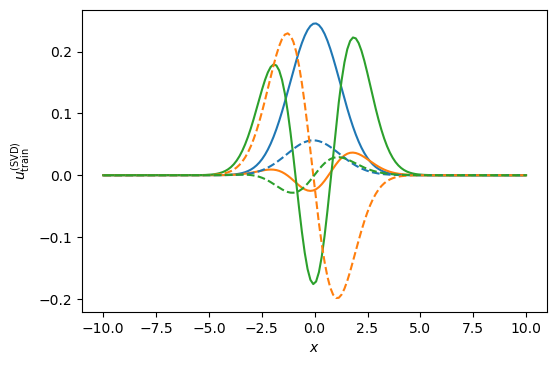

In [22]:
#We select three basis and obtain the following gorgeous functions:
nbasis = 3

fig, ax = plt.subplots(dpi=100)
fig.patch.set_facecolor('white')


    
for i in range(nbasis):
    ax.plot(x, np.real(RBM_stuff[2][0][i , :]))


plt.gca().set_prop_cycle(None)
    
for i in range(nbasis):
    ax.plot(x, np.imag(RBM_stuff[2][0][i , :]),linestyle="dashed")    
    

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$u_{\rm train}^{({\rm SVD})}$');

In [23]:
#Function that runs the time evolution of the system
def solve_linear_system_continuos(RBM_stuff, Omega_Val, total_time, time_steps,total_order):
    
    
    A=-1j*(RBM_stuff[0][0]+Omega_Val**2*RBM_stuff[0][1])
    y0=RBM_stuff[1][2]

    state_evolution = []
    time_step_size=total_time/time_steps
    
    current_state = y0/np.linalg.norm(y0)
    
    
    state_evolution.append(current_state)

    for _ in range(time_steps):

        next_state= np.copy(current_state)
    
        current_correction=np.copy(current_state)
        
                
        for j in range(1,total_order+1):
            current_correction = np.dot( 1/j*time_step_size*A,current_correction)
            next_state= next_state + current_correction
      
        
        next_state = next_state/np.linalg.norm(next_state)
        
        state_evolution.append(next_state)

        current_state = np.copy(next_state)

    return np.array(state_evolution)



In [24]:
%%time
sol_rbm=solve_linear_system_continuos(RBM_stuff,Omega_Val0, 10,10000,4)

CPU times: user 102 ms, sys: 1.09 ms, total: 103 ms
Wall time: 101 ms


Super fast for a specific case! We can also check how the wave function looks across the entire evolution

In [25]:
wf_rbms= np.array([np.dot(sol_rbm[i],RBM_stuff[1][1]) for i in range(len(sol_rbm))] )

In [26]:


rho_rbms = np.array([np.real(wf_rbms[i]*np.conj(wf_rbms[i]))  for i in range(len(sol_rbm))])

In [27]:
RB_rho_movie=rho_rbms[::math.ceil(len(rho_rbms)/((frame_per_second*seconds_total)))]

In [28]:
RB_wf_movie=wf_rbms[::math.ceil(len(wf_rbms)/((frame_per_second*seconds_total)))]

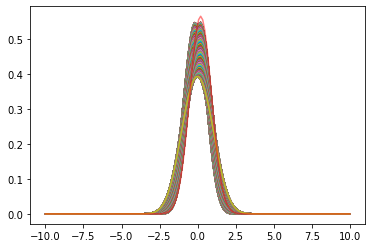

In [29]:

plt.plot(x,RB_rho_movie.T)
plt.plot(x,initial_state*np.conj(initial_state)/(np.dot(initial_state,np.conj(initial_state))*dx),color='r',alpha=0.5)
# plt.xlim(-3,3)
plt.show()

And lets also make a movie!

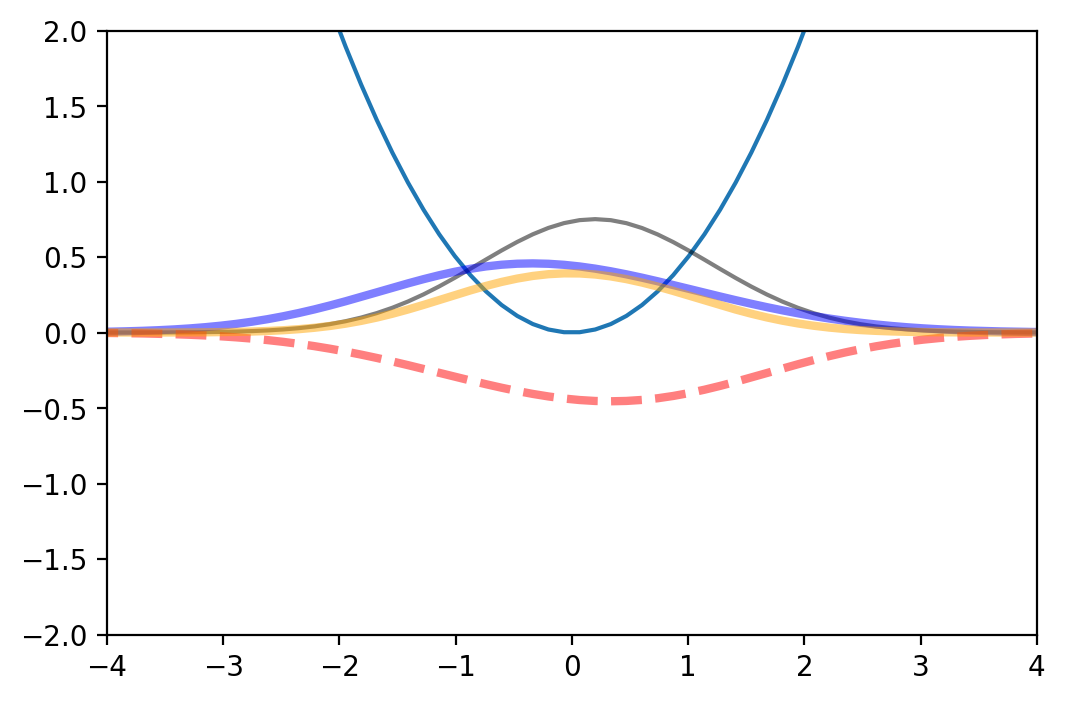

In [30]:
# Movie_Maker(RB_wf_movie,RB_rho_movie,Omega_Val0,'RB_solver')

The next function creates a movie to compare two obtained densities. We can use it to check if the RBM is reproducing the evolution of the high fidelity density

In [33]:
def Movie_Maker_densities(list_of_rhos1,list_of_rhos2,Omega_Value,name,legends):

    fig = plt.figure(dpi=200)
    ax = plt.axes(xlim=(-4, 4), ylim=(-2, 2))
    ax.plot(x,0.5 * Omega_Value**2 * x**2)
    plt.plot(x,(np.conj(initial_state)*initial_state)/((np.dot(initial_state,np.conj(initial_state))*dx)),color='k',alpha=0.5)
    
    
    line, = ax.plot([], [], lw=3,color='orange',alpha=0.5,label=legends[0])
    line2, = ax.plot([], [], lw=3,linestyle='dashed',color='g',alpha=0.5,label=legends[1])
    plt.legend(fontsize=10,frameon=True, edgecolor='black')

    def init():
        line.set_data([], [])
        return line,
    
    
    def animate(i):


        line.set_data(x,list_of_rhos1[i] )
        
        
        line2.set_data(x,list_of_rhos2[i] )
#         line3.set_data(x,rholists[i])
        return line,





    anim = FuncAnimation(fig, animate, init_func=init,
                                  frames=min(len(list_of_rhos1),len(list_of_rhos2)),    blit=True)


    FFwriter = animation.FFMpegWriter(fps=frame_per_second)
    anim.save(name+'_Densities.mp4', writer=FFwriter)

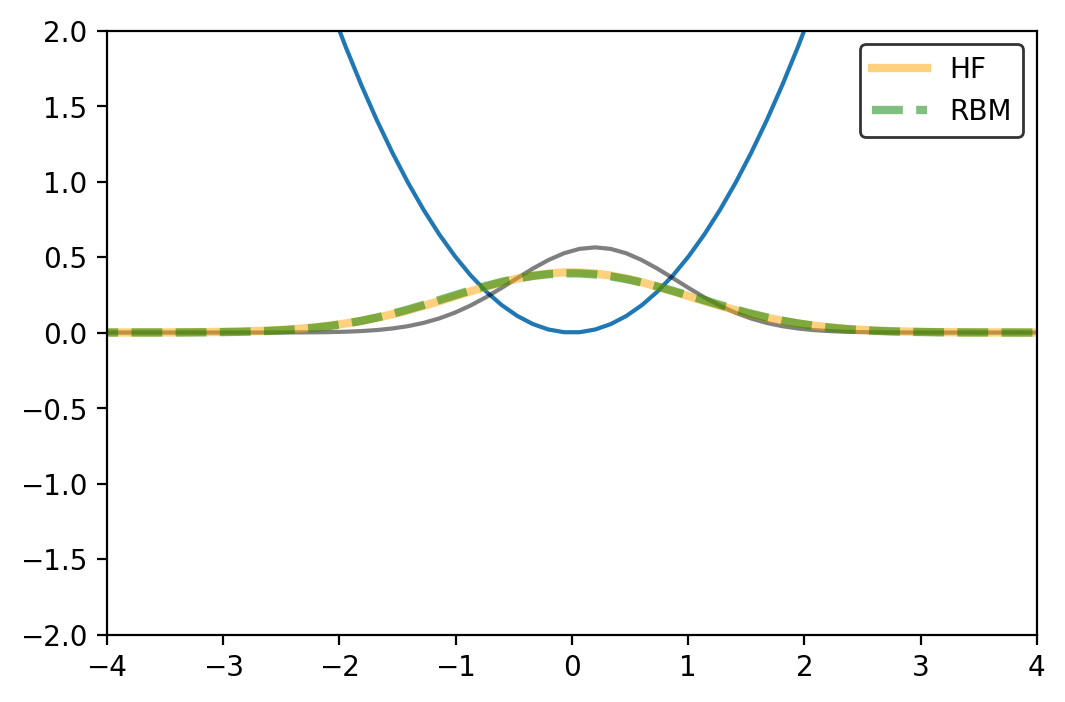

In [34]:
# Movie_Maker_densities(rho_HF0,RB_rho_movie,Omega_Val0,'RB-HF0',['HF','RBM'])

Looks good for this particular example

# Comparing the RBM and the High Fidelity for a fixed value of $\omega$

In [35]:
#This function defines a metric for us to judge how our methods work
def metric_function(true_list_full,calculated_list_full):


    x_calc=np.linspace(-x_max, x_max, 1000)
    
    dx=x_calc[1]-x_calc[0]
    
    x_true=np.linspace(-x_max, x_max, len(true_list_full[-1]))
    x_calc=np.linspace(-x_max, x_max, len(calculated_list_full[-1]))
    
    f_true=CubicSpline(x_true, true_list_full[-1])
    f_calc=CubicSpline(x_calc, calculated_list_full[-1])
    
    return np.linalg.norm(f_true(x_calc)-f_calc(x_calc))/np.linalg.norm(f_true(x_calc))

In [36]:
metric_function(HF_results0[1],rho_rbms)

0.017484555884774013

For the case we had before, it seems to be working well!

In [37]:
#central configuration:[time steps, total order, N_grid]
cent_config=[10000,3,150]

In [38]:
#This is the "truth" that we will compare against
super_HF_config=[20000,6,400]

In [39]:
%%time
HF_results_super=harmonic_oscillator_time_evolution(initial_state, 10, super_HF_config[0], Omega_Val0,super_HF_config[1],super_HF_config[2])

CPU times: user 14min 7s, sys: 34min 35s, total: 48min 42s
Wall time: 2min 26s


It takes a long time!

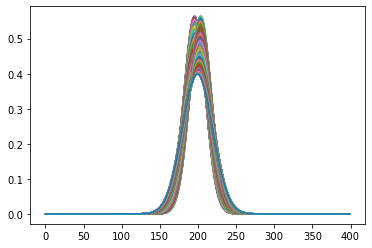

In [40]:
#This is how that very high resolution high fidelity solution looks like:
plt.plot(HF_results_super[1][::100].T)
plt.show()

In [41]:
#Different configurations for the high fidelity

HF_configs1=[
    
    
    [cent_config[0],cent_config[1],cent_config[2]],
     
    [cent_config[0],cent_config[1],40],
    [cent_config[0],cent_config[1],60],
    [cent_config[0],cent_config[1],80],
    [cent_config[0],cent_config[1],100],
    [cent_config[0],cent_config[1],200],
    [cent_config[0],cent_config[1],300],
 
    
]

In [42]:
HF_res_conf1=[]


In [43]:
#Lets compute how the different High Fidelity approaches are doing in comparison to the really precise one

for i in range(len(HF_configs1)):
    
    st = time.time()
    res_dummy= harmonic_oscillator_time_evolution(initial_state, 10, HF_configs1[i][0], Omega_Val0,HF_configs1[i][1],HF_configs1[i][2])
    et = time.time()
    print(HF_configs1[i],et-st)
    HF_res_conf1.append([et-st,metric_function(HF_results_super[1],res_dummy[1])])
    
    
    

[10000, 3, 150] 6.049285411834717
[10000, 3, 40] 0.19251394271850586
[10000, 3, 60] 0.22269678115844727
[10000, 3, 80] 1.1031908988952637
[10000, 3, 100] 1.5019428730010986
[10000, 3, 200] 20.92787480354309
[10000, 3, 300] 22.826255559921265


In [44]:
HF_res_conf1=np.array(HF_res_conf1)

The following funtion evaluates the RBM 100 times when computing the solution so we can have a better idea of how long it takes to evaluate

In [45]:
def RBM_res_maker(rbm_config,HF_results_super):
    #rbm_config = [numb basis, order, steps]
    numb_basis, order, steps =rbm_config

    RBM_stuff_temp=Galerkin_Helper(HF_results_super[0],numb_basis,len(HF_results_super[0][1]))
    
    st=time.time()
    sol_rbm=solve_linear_system_continuos(RBM_stuff_temp,Omega_Val0, 10,steps,order)
    et=time.time()
    
    number_calcs=100
    
    execution_time = timeit.timeit(lambda: solve_linear_system_continuos(RBM_stuff_temp,Omega_Val0, 10,steps,order), number=number_calcs)
    

    wf_rbms= np.array([np.dot(sol_rbm[i],RBM_stuff_temp[1][1]) for i in range(len(sol_rbm))] )

    rho_rbms = np.array([np.real(wf_rbms[i]*np.conj(wf_rbms[i]))  for i in range(len(sol_rbm))])
    
    
    
    return [execution_time/number_calcs, metric_function(HF_results_super[1],rho_rbms) ]

    

We create several configurations of the RB system. Note that now we can change not only the basis number $n$, but also the time step taken $\Delta t$, as well as the total order on the reduced Hamiltonian expansion.

In [48]:
RBM_configs1=[
    
    [6,6,100],
    [7,6,100],
    [8,6,100],
    [9,6,100],
    [12,6,100],
    [15,6,100],
    [15,6,200],
    [18,6,200],
    [18,6,300],
    
    [2,2,50],
    [3,3,70],
    [6,4,70],
    [6,4,100],
    [7,4,100],

    
]





In [49]:
res_rbm1=[]
for i in range(len(RBM_configs1)):
    
    res_rb=RBM_res_maker(RBM_configs1[i],HF_results_super)
    res_rbm1.append(res_rb)
    
    print(RBM_configs1[i],res_rb)
res_rbm1=np.array(res_rbm1)




[6, 6, 100] [0.002041093859988905, 0.0016046550153267945]
[7, 6, 100] [0.00186289362000025, 0.00035783405861791864]
[8, 6, 100] [0.002309614280002279, 0.0002148565946228041]
[9, 6, 100] [0.0021074782799951207, 6.295439393898162e-05]
[12, 6, 100] [0.0021446347699929902, 8.447686995178741e-06]
[15, 6, 100] [0.0021209885200005373, 4.674995713984094e-05]
[15, 6, 200] [0.003636440180016507, 3.4941366387066083e-07]
[18, 6, 200] [0.003813176410003507, 3.026078519192635e-08]
[18, 6, 300] [0.0054489675300101225, 7.585840713840379e-09]
[2, 2, 50] [0.001217822039998282, 0.24715577041663786]
[3, 3, 70] [0.0011377165500016417, 0.021654829164243102]
[6, 4, 70] [0.0014645477900012338, 0.0021966204719722974]
[6, 4, 100] [0.0017716050700073537, 0.001162328400873993]
[7, 4, 100] [0.0017636181699890584, 0.0003315603863323719]


In [50]:
total_rbms=np.array(res_rbm1)

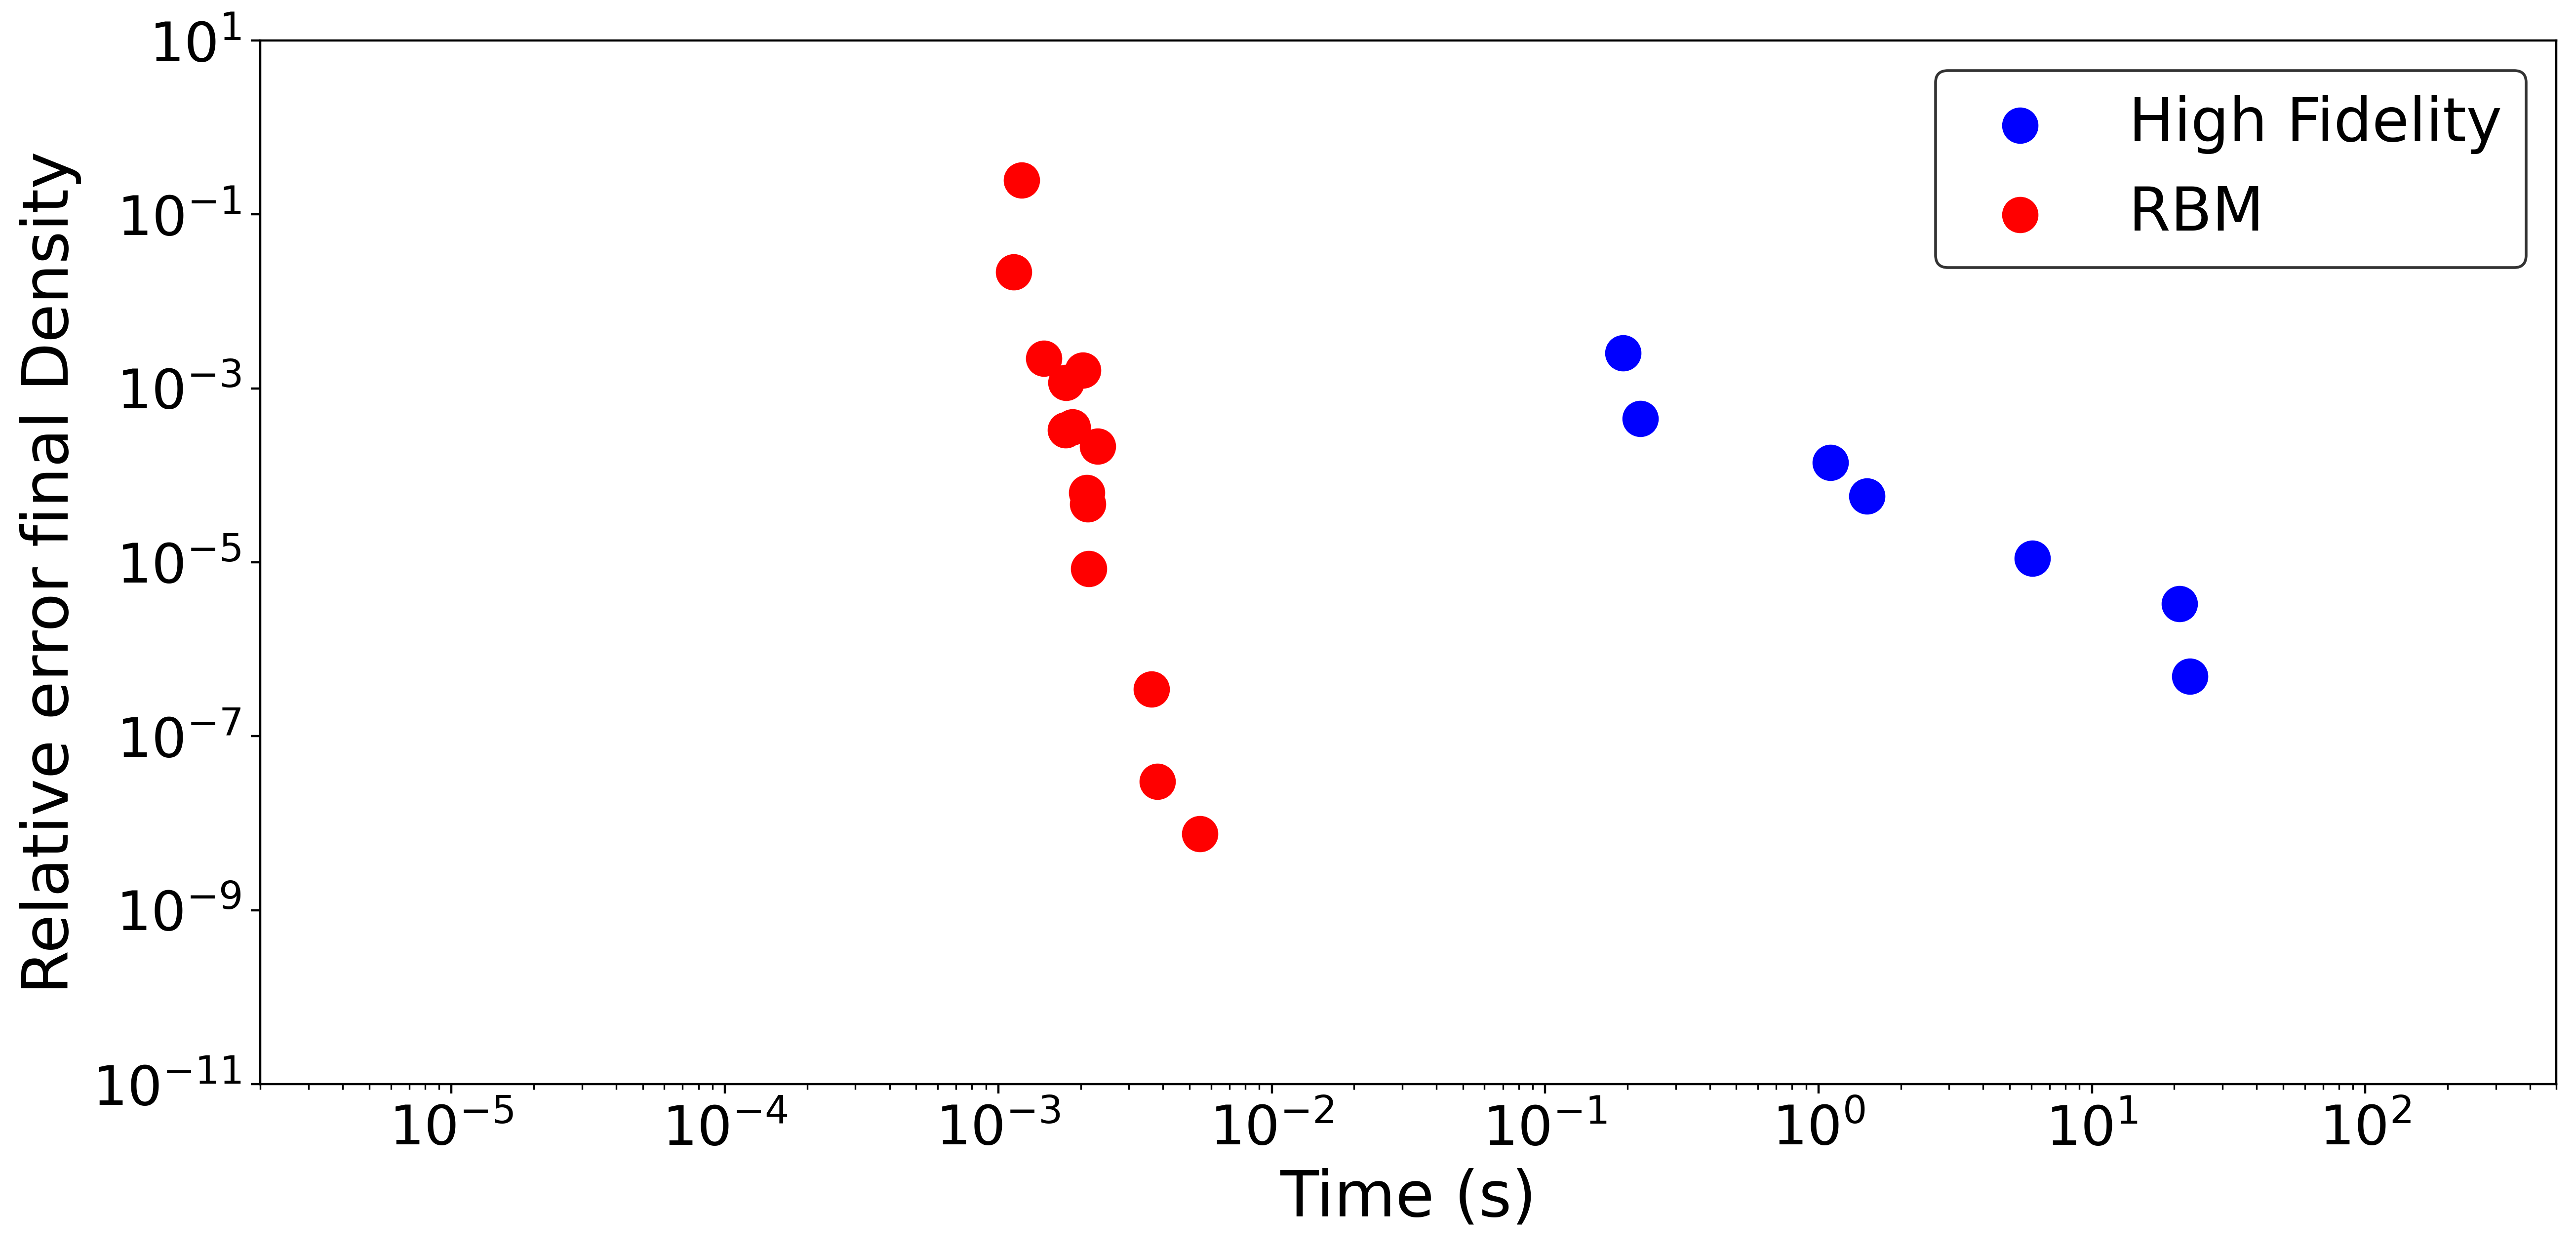

In [53]:
fig, ax = plt.subplots(figsize=(15,7),dpi=400)


 
ax.scatter(HF_res_conf1.T[0],HF_res_conf1.T[1],s=150,color='b',label='High Fidelity')


ax.scatter(total_rbms.T[0],total_rbms.T[1],s=150,color='r',label='RBM')



ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel('Time (s)',fontsize=23)
ax.set_ylabel('Relative error final Density ',fontsize=23)

ax.legend(fontsize=22,frameon=True, edgecolor='black') 
plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)

plt.xlim(2*10**(-6), 5*10**(2))
plt.ylim(10**(-11), 10**(1))

# show the plot
plt.show()

This Computational Accuracy vs Time plot (CAT plot) is an excellent way to compare the performance of the RB emulator with other methods like the high fidelity solver. Each method will trade accuracy for speed through some mechanism to control detail: the mesh size in the case of the finite element and the number of basis in the case of the RBM. Under these metrics the RBM is CATegorically different (for good) in this example when compare with the traditional way of solving the problem.

We only observed the variation in time of the solution for a fixed value of the parameter $\omega$, but the generalization to emulate across $\omega$ is straighforward (and indeed works well!). Give it a try, train the RB for several values of the parameters and create your own reduced order dynamical model. If you take a close look at each coefficient for different values of the parameter $\omega$ you might find some patterns. What would happen if we run a Principal Component Analysis on those? Could we reduce the dimensionality of our system even further?

Join us in the next chapter where we explore the time evolution of a more complicated nonlinear system!